# Extracting the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


# Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim

# Using Cuda

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Dataset and Dataloader and Seeing the images

In [4]:
train = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
test = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
val = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

In [5]:
tr_label = train["label"]
tr_pixel_vals = train.drop("label",axis = 1)

tst_label = test["id"]
tst_pixel_vals = test.drop("id", axis = 1)

v_label = val['label']
v_pixel_vals = val.drop("label",axis = 1)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, labels, pixel_vals, transform=None, target_transform=None):
        self.labels = labels
        self.pixels = pixel_vals
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        pixel_values = self.pixels[idx].astype(float).reshape(28, 28)  # Convert pixel values to float
        label = self.labels[idx]  # Assuming the label is in the second column

        if self.transform:
            pixel_values = self.transform(pixel_values)

        if self.target_transform:
            label = self.target_transform(label)

        return pixel_values, label

Train = CustomImageDataset(tr_label, tr_pixel_vals.values)
Test = CustomImageDataset(tst_label, tst_pixel_vals.values)
Val = CustomImageDataset(v_label, v_pixel_vals.values)

In [7]:
train_dataloader = DataLoader(Train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(Test, batch_size=64, shuffle=True)
val_dataloader = DataLoader(Val, batch_size = 64, shuffle = True)

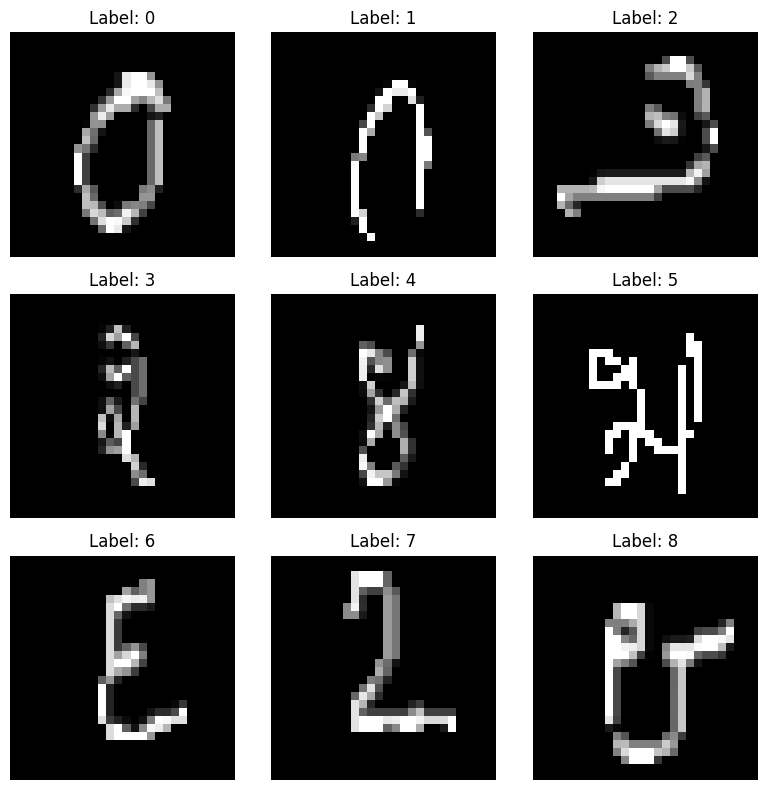

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for idx in range(9):
    pixel_values, label = Train[idx]
    image = pixel_values

    row_idx = idx // 3
    col_idx = idx % 3
    axes[row_idx, col_idx].imshow(image, cmap='gray')
    axes[row_idx, col_idx].set_title(f"Label: {label}")
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

# Display image and label.

Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])


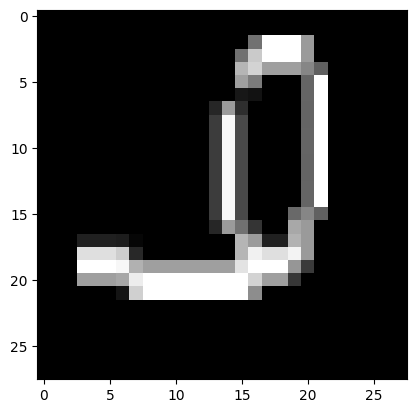

Label: 2


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Define the neural network architecture

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = x.type(self.linear_relu_stack[0].weight.dtype)
        logits = self.linear_relu_stack(x)
        return logits

# Instantiate the model

In [11]:
model = NeuralNetwork()

# Define loss function and optimizer and Lists to store loss values

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

# Training loop

In [13]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Append loss values to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch [1/10] - Train Loss: 129.9026, Train Accuracy: 96.10%
Epoch [1/10] - Validation Loss: 324.9238, Validation Accuracy: 64.37%
Epoch [2/10] - Train Loss: 57.1725, Train Accuracy: 98.18%
Epoch [2/10] - Validation Loss: 418.7641, Validation Accuracy: 61.47%
Epoch [3/10] - Train Loss: 39.0168, Train Accuracy: 98.77%
Epoch [3/10] - Validation Loss: 378.7933, Validation Accuracy: 65.40%
Epoch [4/10] - Train Loss: 34.4505, Train Accuracy: 98.97%
Epoch [4/10] - Validation Loss: 416.8198, Validation Accuracy: 65.03%
Epoch [5/10] - Train Loss: 30.5379, Train Accuracy: 99.09%
Epoch [5/10] - Validation Loss: 542.7212, Validation Accuracy: 62.20%
Epoch [6/10] - Train Loss: 25.6133, Train Accuracy: 99.26%
Epoch [6/10] - Validation Loss: 705.2035, Validation Accuracy: 65.16%
Epoch [7/10] - Train Loss: 26.1698, Train Accuracy: 99.22%
Epoch [7/10] - Validation Loss: 462.5485, Validation Accuracy: 66.10%
Epoch [8/10] - Train Loss: 27.0305, Train Accuracy: 99.28%
Epoch [8/10] - Validation Loss: 566.0

# Plotting the loss graph

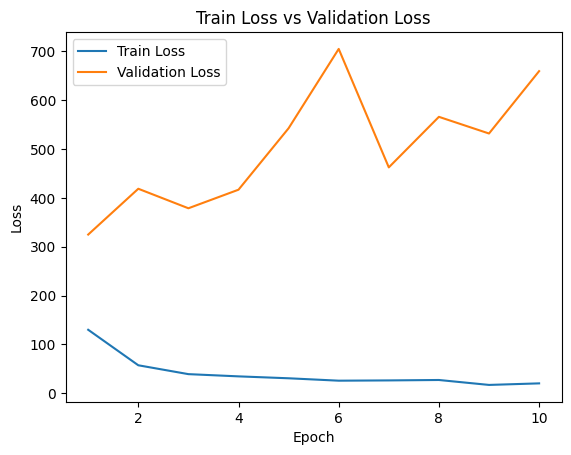

In [14]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

# Adding Regularization

In [15]:
import torch.nn.functional as F

# Define the neural network architecture with L2 regularization
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = x.type(self.linear_relu_stack[0].weight.dtype)
        logits = self.linear_relu_stack(x)
        return logits

# Instantiate the model
model = NeuralNetwork()

# Define loss function and optimizer with weight decay (L2 regularization)
weight_decay = 1e-5  # You can adjust this value
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Training loop with L2 regularization
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Add L2 regularization term to the loss
        l2_reg = sum(p.norm(2) for p in model.parameters())
        loss += weight_decay * l2_reg
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/10] - Train Loss: 129.5772, Train Accuracy: 95.94%
Epoch [1/10] - Validation Loss: 413.1818, Validation Accuracy: 61.94%
Epoch [2/10] - Train Loss: 56.8720, Train Accuracy: 98.31%
Epoch [2/10] - Validation Loss: 327.7598, Validation Accuracy: 66.69%
Epoch [3/10] - Train Loss: 39.8151, Train Accuracy: 98.75%
Epoch [3/10] - Validation Loss: 361.3685, Validation Accuracy: 65.97%
Epoch [4/10] - Train Loss: 34.1189, Train Accuracy: 98.97%
Epoch [4/10] - Validation Loss: 369.1455, Validation Accuracy: 65.02%
Epoch [5/10] - Train Loss: 28.4110, Train Accuracy: 99.17%
Epoch [5/10] - Validation Loss: 450.6547, Validation Accuracy: 64.32%
Epoch [6/10] - Train Loss: 26.3915, Train Accuracy: 99.25%
Epoch [6/10] - Validation Loss: 533.7873, Validation Accuracy: 66.00%
Epoch [7/10] - Train Loss: 24.6774, Train Accuracy: 99.30%
Epoch [7/10] - Validation Loss: 649.0131, Validation Accuracy: 63.25%
Epoch [8/10] - Train Loss: 21.8898, Train Accuracy: 99.38%
Epoch [8/10] - Validation Loss: 632.9

-----------------------------------------------------------------------------------------------------------------------------------------------------